In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/Colab Notebooks/two_stage_af_pred/")

Mounted at /content/drive


Train subjects: [10001 10002 10003 10005 10006 10007 10013 10015 10019 10020 10024 10025
 10028 10029 10032 10034 10035 10038 10039 10043 10044 10045 10046 10047
 10050 10051 10052 10054 10055 10056 10057 10060 10063 10064 10065 10067
 10069 10072 10073 10074 10076 10077 10085 10086 10087 10088 10089 10091
 10092 10094 10095 10096 10097 10099 10101 10102 10104 10111 10113 10114
 10115 10116 10117 10118 10119 10120 10125 10127 10130 10131 10132 10133
 10134 10138 10139 10140 10141 10142 10146 10147 10148 10149 10152 10153
 10154 10155 10156 10157 10160 10163 11002 11003 11004 11005 11007 11010
 11011 11012 11013 11014 11016 11017 11018 11019 11021 11024 11025 11029
 11030 11031 11032 11033 11034 11036 11039 11040 11041 11043 11046 11048
 11052 11054] -> 122
Validation subjects: [10008 10012 10018 10023 10027 10031 10041 10048 10049 10059 10061 10062
 10066 10079 10083 10090 10105 10106 10109 10110 10112 10128 10129 10143
 10162 10164 10166 11001 11006 11015 11023 11027 11038 11042 11044

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 12, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,706 (2.67 MB)

 Trainable params: 700,706 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Best threshold: 0.5811
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Sensitivity (Recall): 0.7241
Specificity: 0.9610
Precision: 0.8750
F1 Score (weighted): 0.8930
AUPRC: 0.9464
AUROC: 0.9767
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        77
           1       0.88      0.72      0.79        29

    accuracy                           0.90       106
   macro avg       0.89      0.84      0.86       106
weighted avg       0.89      0.90      0.89       106



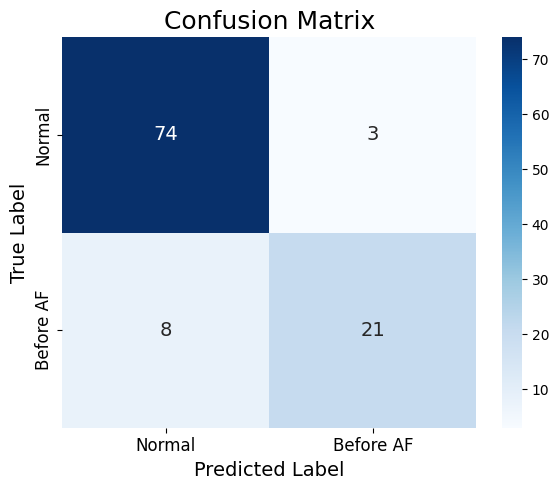

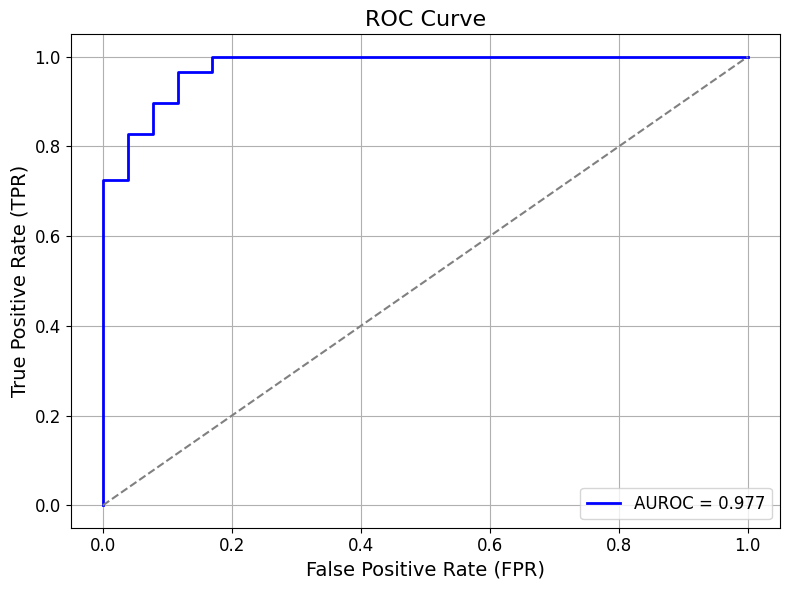

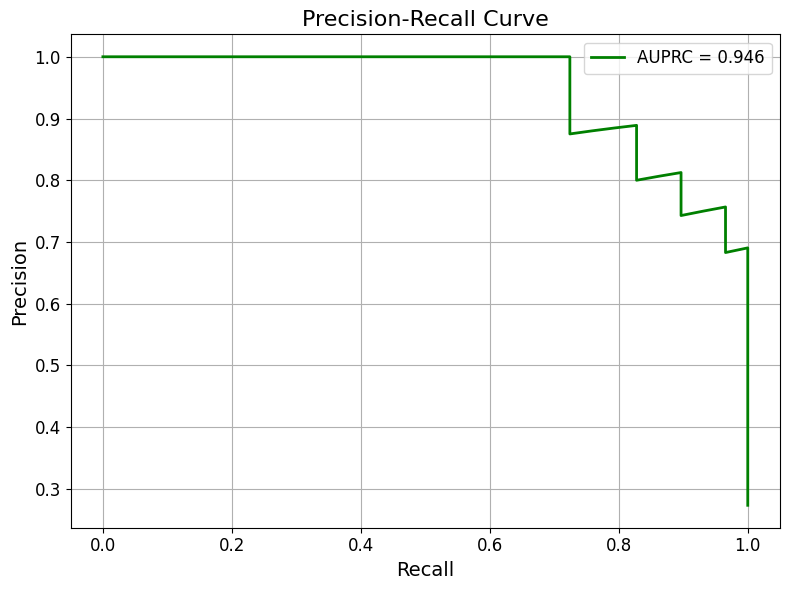

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def extract_features(data, feature_extractor, time_N):
    num_samples, sequence_length = data.shape

    # Remove the 1 h to AF onset segment
    last_segments = data[:, :-3600]
    last_segments = last_segments[:, -(600 * time_N):]

    num_segments = last_segments.shape[1] // 600
    reshaped_data = np.reshape(last_segments, (num_samples * num_segments , 600, 1))
    extracted_features = feature_extractor.predict(reshaped_data, batch_size=32)

    # Reshape back to (N, seg, 128)
    return np.reshape(extracted_features, (num_samples, num_segments, 128))


def build_sequential_DNN(input_shape=(6, 128)):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load data up to 3 hours before AF
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_long_term_3h.mat')
data = loadmat(data_path)

datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten(), 'subject': data['train_subject'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten(), 'subject': data['train2_subject'].flatten()},
]

# Load the saved .npz file to get the same valid test subject which trained in first stage.
data = np.load('Models/data_final_3h.npz', allow_pickle=True)

val_subjects = data['val_subjects']
test_subjects = data['test_subjects']

all_data = np.concatenate([d['data'] for d in datasets], axis=0)
all_labels = np.concatenate([d['label'] for d in datasets], axis=0)
all_subjects = np.concatenate([d['subject'] for d in datasets], axis=0)

val_mask = np.isin(all_subjects, val_subjects)
test_mask = np.isin(all_subjects, test_subjects)
train_mask = ~(val_mask | test_mask)

train_data = all_data[train_mask]
train_label = all_labels[train_mask]
train_subjects = all_subjects[train_mask]

x_valid = all_data[val_mask]
y_valid = all_labels[val_mask]

x_test = all_data[test_mask]
y_test = all_labels[test_mask]

# Sanity check
print("Train subjects:", np.unique(train_subjects), "->", len(np.unique(train_subjects)))
print("Validation subjects:", np.unique(all_subjects[val_mask]), "->", len(np.unique(all_subjects[val_mask])))
print("Test subjects:", np.unique(all_subjects[test_mask]), "->", len(np.unique(all_subjects[test_mask])))

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Load pretrained first stage model
pretrained_model_path = "Models/model_final_3h.h5"
pretrained_model = load_model(pretrained_model_path)
pretrained_model.trainable = False  # Freeze pretrained model

# Extract Dense(128) output from pretrained model
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer("dense").output)
X_train_features = extract_features(x_train_final, feature_extractor,time_N = 12)
X_valid_features = extract_features(x_valid, feature_extractor,time_N = 12)
X_test_features = extract_features(x_test, feature_extractor,time_N = 12)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# compile second stage model
sequential_model = build_sequential_DNN(input_shape=(X_train_features.shape[1], X_train_features.shape[2]))

sequential_model.summary()

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
sequential_model.compile(optimizer=optimizer,
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

# # Train second stage model
# history = sequential_model.fit(
#     X_train_features, y_train_final,
#     validation_data=(X_valid_features, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     shuffle=True,
#     callbacks=early_stopping
# )

sequential_model.load_weights("Models/Sequential_120min.h5")

# Save the final trained model
# sequential_model.save(f"Models/Sequential_120min.h5")
# np.savez(f'Models/data_120min_result2.npz',
#       X_train=X_train_features,
#       y_train=y_train_final,
#       X_valid=X_valid_features,
#       y_valid=y_valid,
#       X_test=X_test_features,
#       y_test=y_test)


# Predict probabilities on validation set
val_prob = sequential_model.predict(X_valid_features)
val_scores = val_prob[:, 1]
val_true = y_valid

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Predict probabilities on test set
y_prob = sequential_model.predict(X_test_features)
y_scores = y_prob[:, 1]
y_true = y_test

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Train subjects: [10001 10002 10003 10005 10006 10007 10013 10015 10019 10020 10024 10025
 10028 10029 10032 10034 10035 10038 10039 10043 10044 10045 10046 10047
 10050 10051 10052 10054 10055 10056 10057 10060 10063 10064 10065 10067
 10069 10072 10073 10074 10076 10077 10085 10086 10087 10088 10089 10091
 10092 10094 10095 10096 10097 10099 10101 10102 10104 10111 10113 10114
 10115 10116 10117 10118 10119 10120 10125 10127 10130 10131 10132 10133
 10134 10138 10139 10140 10141 10142 10146 10147 10148 10149 10152 10153
 10154 10155 10156 10157 10160 10163 11002 11003 11004 11005 11007 11010
 11011 11012 11013 11014 11016 11017 11018 11019 11021 11024 11025 11029
 11030 11031 11032 11033 11034 11036 11039 11040 11041 11043 11046 11048
 11052 11054] -> 122
Validation subjects: [10008 10012 10018 10023 10027 10031 10041 10048 10049 10059 10061 10062
 10066 10079 10083 10090 10105 10106 10109 10110 10112 10128 10129 10143
 10162 10164 10166 11001 11006 11015 11023 11027 11038 11042 11044

127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 9, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,706 (2.67 MB)

 Trainable params: 700,706 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Best threshold: 0.3133
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Sensitivity (Recall): 0.8621
Specificity: 0.9351
Precision: 0.8333
F1 Score (weighted): 0.9155
AUPRC: 0.9449
AUROC: 0.9776
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        77
           1       0.83      0.86      0.85        29

    accuracy                           0.92       106
   macro avg       0.89      0.90      0.89       106
weighted avg       0.92      0.92      0.92       106



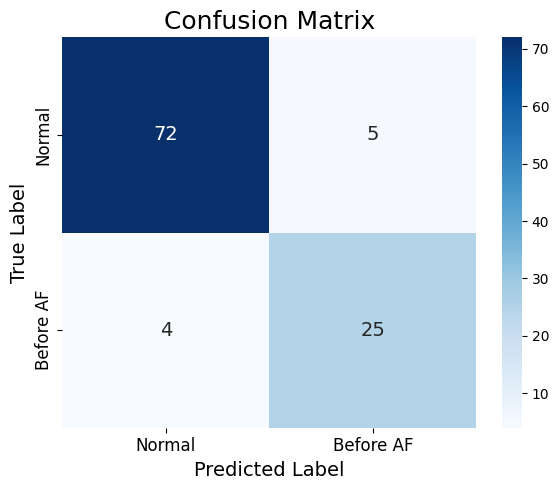

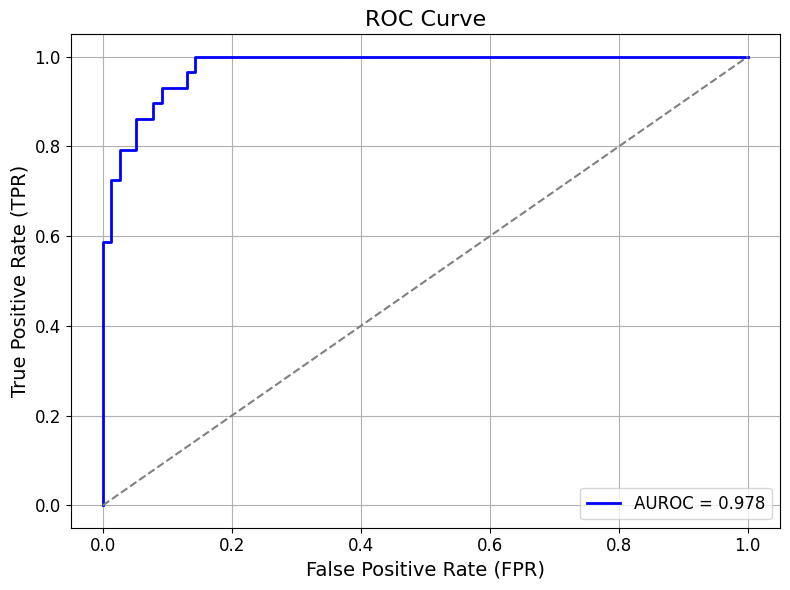

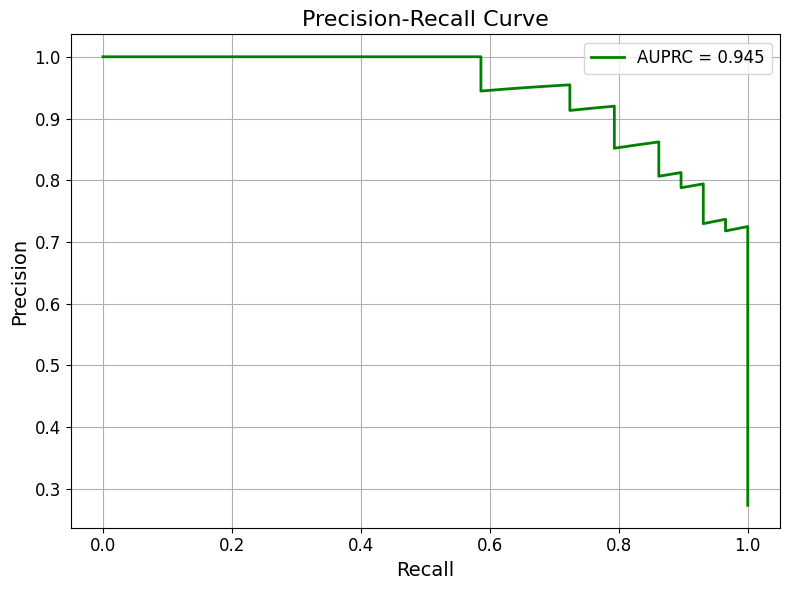

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def extract_features(data, feature_extractor, time_N):
    num_samples, sequence_length = data.shape

    # Remove the 1 h to AF onset segment
    last_segments = data[:, :-3600]
    last_segments = last_segments[:, -(600 * time_N):]

    num_segments = last_segments.shape[1] // 600
    reshaped_data = np.reshape(last_segments, (num_samples * num_segments , 600, 1))
    extracted_features = feature_extractor.predict(reshaped_data, batch_size=32)

    # Reshape back to (N, seg, 128)
    return np.reshape(extracted_features, (num_samples, num_segments, 128))


def build_sequential_DNN(input_shape=(6, 128)):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load data up to 3 hours before AF
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_long_term_3h.mat')
data = loadmat(data_path)

datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten(), 'subject': data['train_subject'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten(), 'subject': data['train2_subject'].flatten()},
]

# Load the saved .npz file to get the same valid test subject which trained in first stage.
data = np.load('Models/data_final_3h.npz', allow_pickle=True)

val_subjects = data['val_subjects']
test_subjects = data['test_subjects']

all_data = np.concatenate([d['data'] for d in datasets], axis=0)
all_labels = np.concatenate([d['label'] for d in datasets], axis=0)
all_subjects = np.concatenate([d['subject'] for d in datasets], axis=0)

val_mask = np.isin(all_subjects, val_subjects)
test_mask = np.isin(all_subjects, test_subjects)
train_mask = ~(val_mask | test_mask)

train_data = all_data[train_mask]
train_label = all_labels[train_mask]
train_subjects = all_subjects[train_mask]

x_valid = all_data[val_mask]
y_valid = all_labels[val_mask]

x_test = all_data[test_mask]
y_test = all_labels[test_mask]

# Sanity check
print("Train subjects:", np.unique(train_subjects), "->", len(np.unique(train_subjects)))
print("Validation subjects:", np.unique(all_subjects[val_mask]), "->", len(np.unique(all_subjects[val_mask])))
print("Test subjects:", np.unique(all_subjects[test_mask]), "->", len(np.unique(all_subjects[test_mask])))

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Load pretrained first stage model
pretrained_model_path = "Models/model_final_3h.h5"
pretrained_model = load_model(pretrained_model_path)
pretrained_model.trainable = False  # Freeze pretrained model

# Extract Dense(128) output from pretrained model
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer("dense").output)
X_train_features = extract_features(x_train_final, feature_extractor,time_N = 9)
X_valid_features = extract_features(x_valid, feature_extractor,time_N = 9)
X_test_features = extract_features(x_test, feature_extractor,time_N = 9)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# compile second stage model
sequential_model = build_sequential_DNN(input_shape=(X_train_features.shape[1], X_train_features.shape[2]))

sequential_model.summary()

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
sequential_model.compile(optimizer=optimizer,
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

# # Train second stage model
# history = sequential_model.fit(
#     X_train_features, y_train_final,
#     validation_data=(X_valid_features, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     shuffle=True,
#     callbacks=early_stopping
# )

sequential_model.load_weights("Models/Sequential_90min.h5")

# Save the final trained model
# sequential_model.save(f"Models/Sequential_90min.h5")
# np.savez(f'Models/data_90min_result2.npz',
#       X_train=X_train_features,
#       y_train=y_train_final,
#       X_valid=X_valid_features,
#       y_valid=y_valid,
#       X_test=X_test_features,
#       y_test=y_test)


# Predict probabilities on validation set
val_prob = sequential_model.predict(X_valid_features)
val_scores = val_prob[:, 1]
val_true = y_valid

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Predict probabilities on test set
y_prob = sequential_model.predict(X_test_features)
y_scores = y_prob[:, 1]
y_true = y_test

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()



Train subjects: [10001 10002 10003 10005 10006 10007 10013 10015 10019 10020 10024 10025
 10028 10029 10032 10034 10035 10038 10039 10043 10044 10045 10046 10047
 10050 10051 10052 10054 10055 10056 10057 10060 10063 10064 10065 10067
 10069 10072 10073 10074 10076 10077 10085 10086 10087 10088 10089 10091
 10092 10094 10095 10096 10097 10099 10101 10102 10104 10111 10113 10114
 10115 10116 10117 10118 10119 10120 10125 10127 10130 10131 10132 10133
 10134 10138 10139 10140 10141 10142 10146 10147 10148 10149 10152 10153
 10154 10155 10156 10157 10160 10163 11002 11003 11004 11005 11007 11010
 11011 11012 11013 11014 11016 11017 11018 11019 11021 11024 11025 11029
 11030 11031 11032 11033 11034 11036 11039 11040 11041 11043 11046 11048
 11052 11054] -> 122
Validation subjects: [10008 10012 10018 10023 10027 10031 10041 10048 10049 10059 10061 10062
 10066 10079 10083 10090 10105 10106 10109 10110 10112 10128 10129 10143
 10162 10164 10166 11001 11006 11015 11023 11027 11038 11042 11044

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 6, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,706 (2.67 MB)

 Trainable params: 700,706 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Best threshold: 0.3312
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Sensitivity (Recall): 0.7931
Specificity: 0.9481
Precision: 0.8519
F1 Score (weighted): 0.9046
AUPRC: 0.9448
AUROC: 0.9763
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        77
           1       0.85      0.79      0.82        29

    accuracy                           0.91       106
   macro avg       0.89      0.87      0.88       106
weighted avg       0.90      0.91      0.90       106



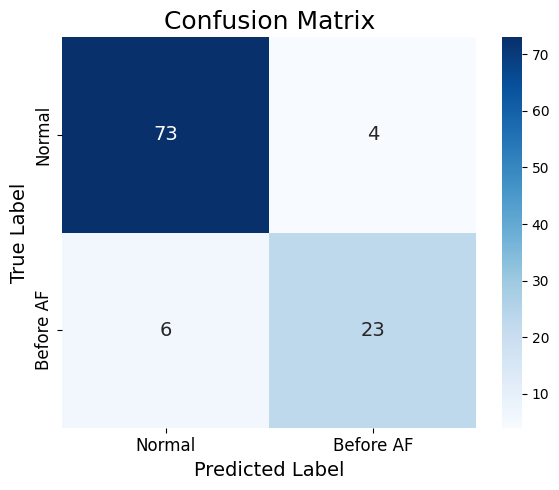

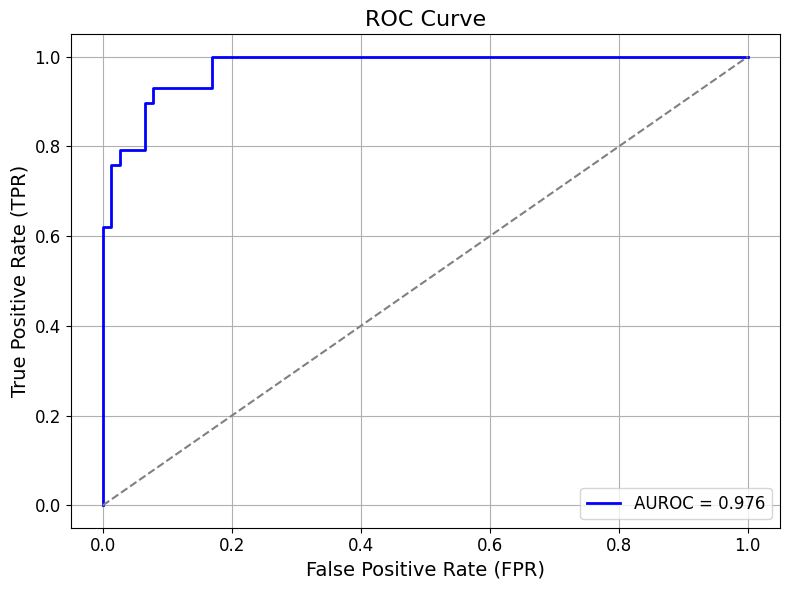

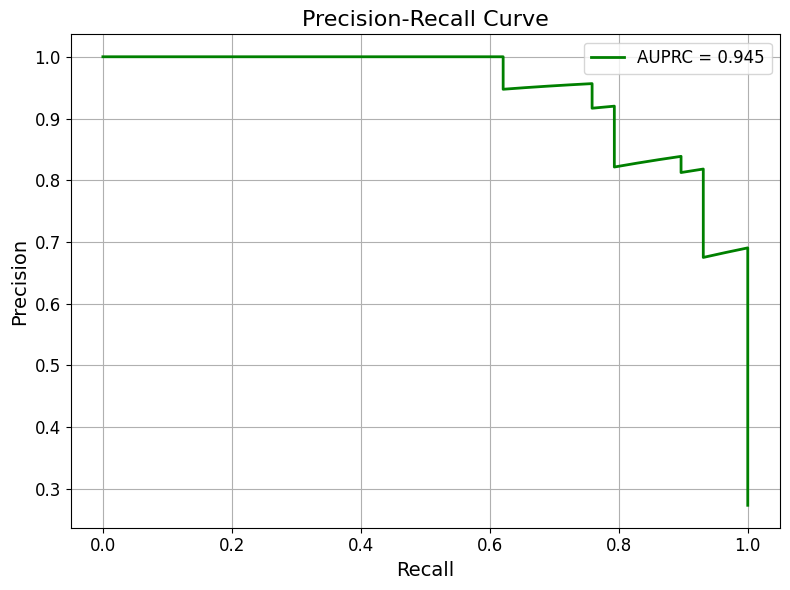

In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def extract_features(data, feature_extractor, time_N):
    num_samples, sequence_length = data.shape

    # Remove the 1 h to AF onset segment
    last_segments = data[:, :-3600]
    last_segments = last_segments[:, -(600 * time_N):]

    num_segments = last_segments.shape[1] // 600
    reshaped_data = np.reshape(last_segments, (num_samples * num_segments , 600, 1))
    extracted_features = feature_extractor.predict(reshaped_data, batch_size=32)

    # Reshape back to (N, seg, 128)
    return np.reshape(extracted_features, (num_samples, num_segments, 128))


def build_sequential_DNN(input_shape=(6, 128)):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load data up to 3 hours before AF
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_long_term_3h.mat')
data = loadmat(data_path)

datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten(), 'subject': data['train_subject'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten(), 'subject': data['train2_subject'].flatten()},
]

# Load the saved .npz file to get the same valid test subject which trained in first stage.
data = np.load('Models/data_final_3h.npz', allow_pickle=True)

val_subjects = data['val_subjects']
test_subjects = data['test_subjects']

all_data = np.concatenate([d['data'] for d in datasets], axis=0)
all_labels = np.concatenate([d['label'] for d in datasets], axis=0)
all_subjects = np.concatenate([d['subject'] for d in datasets], axis=0)

val_mask = np.isin(all_subjects, val_subjects)
test_mask = np.isin(all_subjects, test_subjects)
train_mask = ~(val_mask | test_mask)

train_data = all_data[train_mask]
train_label = all_labels[train_mask]
train_subjects = all_subjects[train_mask]

x_valid = all_data[val_mask]
y_valid = all_labels[val_mask]

x_test = all_data[test_mask]
y_test = all_labels[test_mask]

# Sanity check
print("Train subjects:", np.unique(train_subjects), "->", len(np.unique(train_subjects)))
print("Validation subjects:", np.unique(all_subjects[val_mask]), "->", len(np.unique(all_subjects[val_mask])))
print("Test subjects:", np.unique(all_subjects[test_mask]), "->", len(np.unique(all_subjects[test_mask])))

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Load pretrained first stage model
pretrained_model_path = "Models/model_final_3h.h5"
pretrained_model = load_model(pretrained_model_path)
pretrained_model.trainable = False  # Freeze pretrained model

# Extract Dense(128) output from pretrained model
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer("dense").output)
X_train_features = extract_features(x_train_final, feature_extractor,time_N = 6)
X_valid_features = extract_features(x_valid, feature_extractor,time_N = 6)
X_test_features = extract_features(x_test, feature_extractor,time_N = 6)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# compile second stage model
sequential_model = build_sequential_DNN(input_shape=(X_train_features.shape[1], X_train_features.shape[2]))

sequential_model.summary()

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
sequential_model.compile(optimizer=optimizer,
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

# # Train second stage model
# history = sequential_model.fit(
#     X_train_features, y_train_final,
#     validation_data=(X_valid_features, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     shuffle=True,
#     callbacks=early_stopping
# )

sequential_model.load_weights("Models/Sequential_60min.h5")

# Save the final trained model
# sequential_model.save(f"Models/Sequential_60min.h5")
# np.savez(f'Models/data_60min_result2.npz',
#       X_train=X_train_features,
#       y_train=y_train_final,
#       X_valid=X_valid_features,
#       y_valid=y_valid,
#       X_test=X_test_features,
#       y_test=y_test)


# Predict probabilities on validation set
val_prob = sequential_model.predict(X_valid_features)
val_scores = val_prob[:, 1]
val_true = y_valid

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Predict probabilities on test set
y_prob = sequential_model.predict(X_test_features)
y_scores = y_prob[:, 1]
y_true = y_test

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()



Train subjects: [10001 10002 10003 10005 10006 10007 10013 10015 10019 10020 10024 10025
 10028 10029 10032 10034 10035 10038 10039 10043 10044 10045 10046 10047
 10050 10051 10052 10054 10055 10056 10057 10060 10063 10064 10065 10067
 10069 10072 10073 10074 10076 10077 10085 10086 10087 10088 10089 10091
 10092 10094 10095 10096 10097 10099 10101 10102 10104 10111 10113 10114
 10115 10116 10117 10118 10119 10120 10125 10127 10130 10131 10132 10133
 10134 10138 10139 10140 10141 10142 10146 10147 10148 10149 10152 10153
 10154 10155 10156 10157 10160 10163 11002 11003 11004 11005 11007 11010
 11011 11012 11013 11014 11016 11017 11018 11019 11021 11024 11025 11029
 11030 11031 11032 11033 11034 11036 11039 11040 11041 11043 11046 11048
 11052 11054] -> 122
Validation subjects: [10008 10012 10018 10023 10027 10031 10041 10048 10049 10059 10061 10062
 10066 10079 10083 10090 10105 10106 10109 10110 10112 10128 10129 10143
 10162 10164 10166 11001 11006 11015 11023 11027 11038 11042 11044

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 3, 256)         │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,706 (2.67 MB)

 Trainable params: 700,706 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Best threshold: 0.2782
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Sensitivity (Recall): 0.8276
Specificity: 0.8961
Precision: 0.7500
F1 Score (weighted): 0.8792
AUPRC: 0.8922
AUROC: 0.9445
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        77
           1       0.75      0.83      0.79        29

    accuracy                           0.88       106
   macro avg       0.84      0.86      0.85       106
weighted avg       0.88      0.88      0.88       106



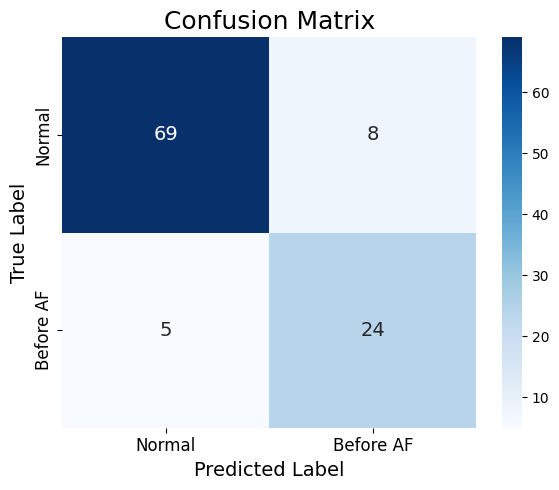

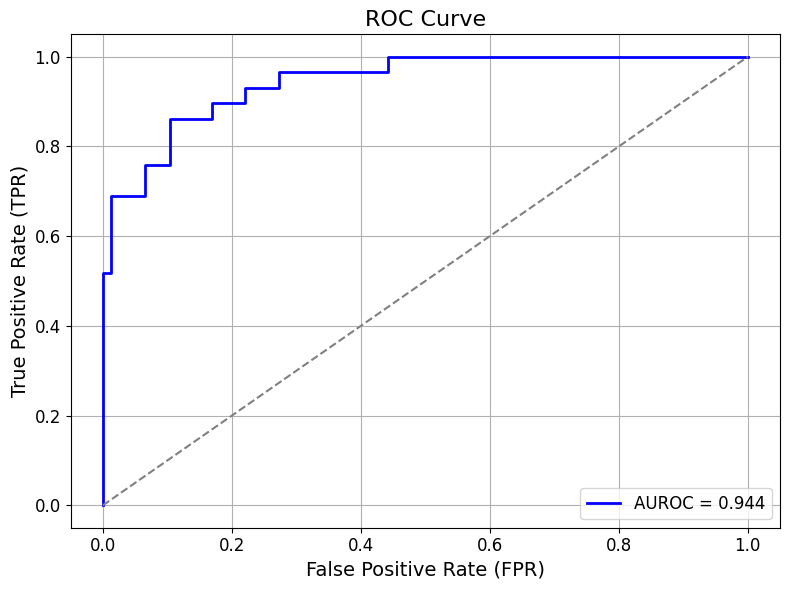

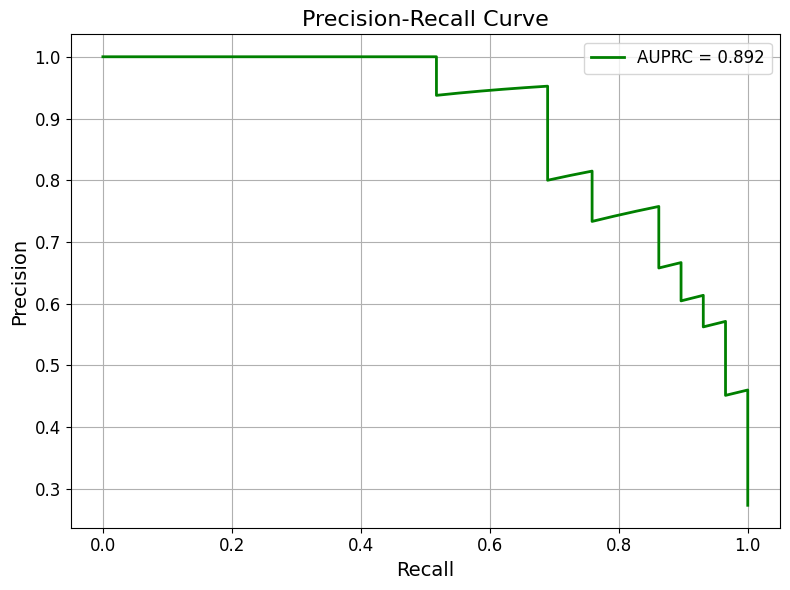

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout,
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping

def extract_features(data, feature_extractor, time_N):
    num_samples, sequence_length = data.shape

    # Remove the 1 h to AF onset segment
    last_segments = data[:, :-3600]
    last_segments = last_segments[:, -(600 * time_N):]

    num_segments = last_segments.shape[1] // 600
    reshaped_data = np.reshape(last_segments, (num_samples * num_segments , 600, 1))
    extracted_features = feature_extractor.predict(reshaped_data, batch_size=32)

    # Reshape back to (N, seg, 128)
    return np.reshape(extracted_features, (num_samples, num_segments, 128))


def build_sequential_DNN(input_shape=(6, 128)):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(128))(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

seed = 79
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Load data up to 3 hours before AF
data_path = os.path.join(os.getcwd(), 'Data/data_RRI_long_term_3h.mat')
data = loadmat(data_path)

datasets = [
    {'data': data['train_data'], 'label': data['train_label'].flatten(), 'subject': data['train_subject'].flatten()},
    {'data': data['train2_data'], 'label': data['train2_label'].flatten(), 'subject': data['train2_subject'].flatten()},
]

# Load the saved .npz file to get the same valid test subject which trained in first stage.
data = np.load('Models/data_final_3h.npz', allow_pickle=True)

val_subjects = data['val_subjects']
test_subjects = data['test_subjects']

all_data = np.concatenate([d['data'] for d in datasets], axis=0)
all_labels = np.concatenate([d['label'] for d in datasets], axis=0)
all_subjects = np.concatenate([d['subject'] for d in datasets], axis=0)

val_mask = np.isin(all_subjects, val_subjects)
test_mask = np.isin(all_subjects, test_subjects)
train_mask = ~(val_mask | test_mask)

train_data = all_data[train_mask]
train_label = all_labels[train_mask]
train_subjects = all_subjects[train_mask]

x_valid = all_data[val_mask]
y_valid = all_labels[val_mask]

x_test = all_data[test_mask]
y_test = all_labels[test_mask]

# Sanity check
print("Train subjects:", np.unique(train_subjects), "->", len(np.unique(train_subjects)))
print("Validation subjects:", np.unique(all_subjects[val_mask]), "->", len(np.unique(all_subjects[val_mask])))
print("Test subjects:", np.unique(all_subjects[test_mask]), "->", len(np.unique(all_subjects[test_mask])))

# Upsample the training data
ros = RandomOverSampler(random_state=seed)
x_train_final, y_train_final = ros.fit_resample(train_data, train_label)

# Load pretrained first stage model
pretrained_model_path = "Models/model_final_3h.h5"
pretrained_model = load_model(pretrained_model_path)
pretrained_model.trainable = False  # Freeze pretrained model

# Extract Dense(128) output from pretrained model
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer("dense").output)
X_train_features = extract_features(x_train_final, feature_extractor,time_N = 3)
X_valid_features = extract_features(x_valid, feature_extractor,time_N = 3)
X_test_features = extract_features(x_test, feature_extractor,time_N = 3)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# compile second stage model
sequential_model = build_sequential_DNN(input_shape=(X_train_features.shape[1], X_train_features.shape[2]))

sequential_model.summary()

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)
sequential_model.compile(optimizer=optimizer,
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

# # Train second stage model
# history = sequential_model.fit(
#     X_train_features, y_train_final,
#     validation_data=(X_valid_features, y_valid),
#     epochs=300,
#     batch_size=32,
#     verbose=1,
#     shuffle=True,
#     callbacks=early_stopping
# )

sequential_model.load_weights("Models/Sequential_30min.h5")

# Save the final trained model
# sequential_model.save(f"Models/Sequential_30min.h5")
# np.savez(f'Models/data_60min_result2.npz',
#       X_train=X_train_features,
#       y_train=y_train_final,
#       X_valid=X_valid_features,
#       y_valid=y_valid,
#       X_test=X_test_features,
#       y_test=y_test)


# Predict probabilities on validation set
val_prob = sequential_model.predict(X_valid_features)
val_scores = val_prob[:, 1]
val_true = y_valid

fpr, tpr, roc_thresholds = roc_curve(val_true, val_scores)
youden_j = tpr - fpr
best_roc_idx = np.argmax(youden_j)
best_threshold = roc_thresholds[best_roc_idx]

print(f"Best threshold: {best_threshold:.4f}")

# Predict probabilities on test set
y_prob = sequential_model.predict(X_test_features)
y_scores = y_prob[:, 1]
y_true = y_test

# Apply best threshold from validation
y_pred = (y_scores >= best_threshold).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_scores)
auprc = auc(rec, prec)

# Metrics
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
precision_val = precision_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Accuracy Matrix
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"AUROC: {roc_auc:.4f}")

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Before AF'],
                yticklabels=['Normal', 'Before AF'],
                annot_kws={"size": 14})
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# AUPRC
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, color='green', lw=2, label=f'AUPRC = {auprc:.3f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()




Processing 30min...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
AUROC: 0.9445, AUPRC: 0.8922

Processing 60min...


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
AUROC: 0.9763, AUPRC: 0.9448

Processing 90min...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
AUROC: 0.9776, AUPRC: 0.9449

Processing 120min...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
AUROC: 0.9767, AUPRC: 0.9464


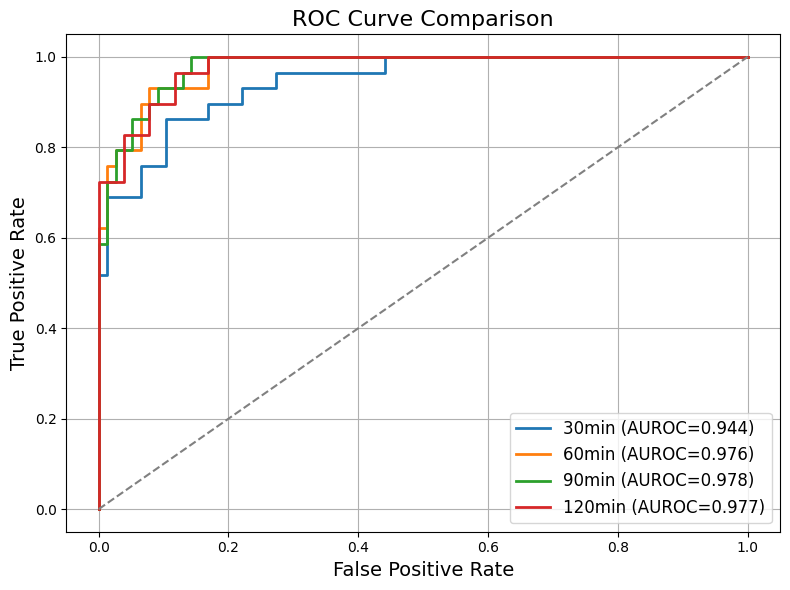

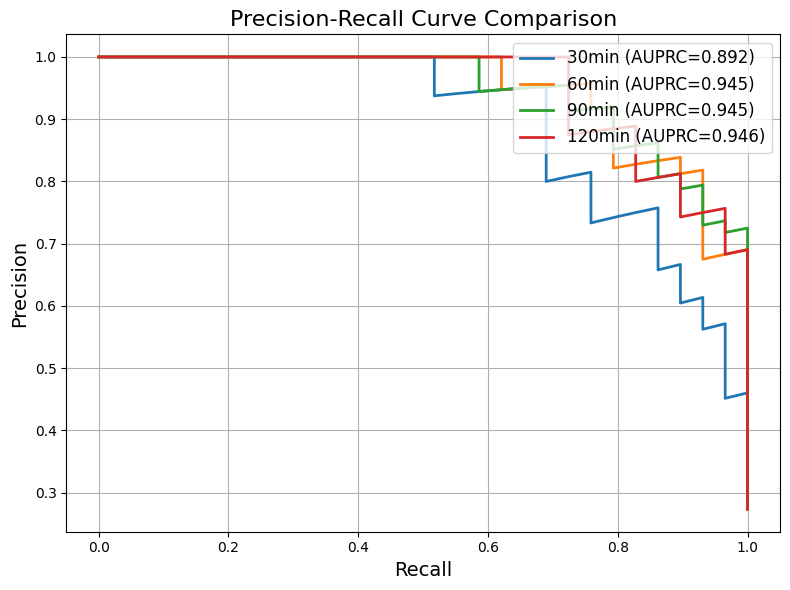


=== Summary ===
30min: AUROC = 0.9445, AUPRC = 0.8922
60min: AUROC = 0.9763, AUPRC = 0.9448
90min: AUROC = 0.9776, AUPRC = 0.9449
120min: AUROC = 0.9767, AUPRC = 0.9464


In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import load_model

# Folder paths for your results
time_intervals = ['30min', '60min', '90min', '120min']
base_path = 'Models/'

# Store results and curves
results = {}
roc_curves = {}
pr_curves = {}

for interval in time_intervals:
    print(f"\nProcessing {interval}...")

    # Load dataset and model
    data = np.load(os.path.join(base_path, f'data_{interval}_result2.npz'))
    model = load_model(os.path.join(base_path, f'Sequential_{interval}.h5'))

    X_test = data['X_test']
    y_test = data['y_test']

    y_prob = model.predict(X_test)

    if y_prob.shape[-1] == 2:
        y_scores = y_prob[:, 1]
    else:
        y_scores = y_prob.flatten()

    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, y_scores, drop_intermediate=False)
    prec, rec, _ = precision_recall_curve(y_test, y_scores, drop_intermediate=False)

    roc_auc = auc(fpr, tpr)
    auprc = auc(rec, prec)

    # Save results
    results[interval] = {'AUROC': roc_auc, 'AUPRC': auprc}
    roc_curves[interval] = (fpr, tpr)
    pr_curves[interval] = (rec, prec)

    print(f"AUROC: {roc_auc:.4f}, AUPRC: {auprc:.4f}")

# Combined AUROC
plt.figure(figsize=(8, 6))
for interval in time_intervals:
    fpr, tpr = roc_curves[interval]
    roc_auc = results[interval]['AUROC']
    plt.plot(fpr, tpr, lw=2, label=f'{interval} (AUROC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Combined AUPRC
plt.figure(figsize=(8, 6))
for interval in time_intervals:
    rec, prec = pr_curves[interval]
    auprc = results[interval]['AUPRC']
    plt.plot(rec, prec, lw=2, label=f'{interval} (AUPRC={auprc:.3f})')

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# Final summary
print("\n=== Summary ===")
for interval, metrics in results.items():
    print(f"{interval}: AUROC = {metrics['AUROC']:.4f}, AUPRC = {metrics['AUPRC']:.4f}")
